# OPS-SAT case starter-kit notebook

ESA's [Kelvins](https://kelvins.esa.int) competition "[the OPS-SAT case](https://kelvins.esa.int/opssat/home/)" is a novel data-centric challenge that asks you to work with the raw data of a satellite and very few provided labels to find the best parameters for a given machine learning model. Compared to previous competitions on Kelvins (like the [Pose Estimation](https://kelvins.esa.int/pose-estimation-2021/) or the [Proba-V Super-resolution challenge](https://kelvins.esa.int/proba-v-super-resolution/)) where the test-set is provided and the infered results are submitted, for the OPS-SAT case, we will run inference on the Kelvins server directly! This notebooks contains examples on how you can load your data and train an **EfficientNetLite0** model by only using the 80-labeled images provided. Therefore, the directory `images`, containing unlabeld patches and included in the training dataset is not used for this notebook. However, competitors are encouraged to use these patches to improve the model accuracy.

# 1. Module imports

In [1]:
seed = 42

import os
os.environ['PYTHONHASHSEED'] = str(seed)

import random
random.seed(seed)

import numpy as np
np.random.seed(seed)

In [2]:
!python3 -m pip install tensorflow==2.7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

If you do not have a GPU, uncomment and run the next commands.

In [4]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

Other imports.

In [5]:
from google.colab import drive
from tensorflow import keras
import matplotlib.pyplot as plt
from skimage.util import random_noise
from sklearn.utils import shuffle
import gc
from sklearn import metrics

In [6]:
tf.__version__

'2.7.0'

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd drive/MyDrive/opssat/opssat_challenge

/content/drive/MyDrive/opssat/opssat_challenge


In [10]:
from efficientnet_lite import EfficientNetLiteB0

# 2. Utility Functions

You can use this function to load your training data.

In [11]:
def get_images_from_path(dataset_path):
    """ Get images from path and normalize them applying channel-level normalization. """

    # loading all images in one large batch
    tf_eval_data = tf.keras.utils.image_dataset_from_directory(dataset_path, image_size=input_shape[:2], shuffle=False,
                                                               batch_size=100000)

    # extract images and targets
    for tf_eval_images, tf_eval_targets in tf_eval_data:
        break

    return tf.convert_to_tensor(tf_eval_images), tf_eval_targets

In [12]:
class_mapping = {0: 'Agriculture',
                 1: 'Cloud',
                 2: 'Mountain',
                 3: 'Natural',
                 4: 'River',
                 5: 'Sea_ice',
                 6: 'Snow',
                 7: 'Water'}

In [13]:
def visualize_image(features, labels, image, pred=False, **kwargs):
    
    plt.imshow(features[image])
    
    print('Class: {}'.format(class_mapping[labels[image]]))
    
    if pred:
        predictions = kwargs.get('predictions', None)
        print('Predicted: {}'.format(class_mapping[predictions[image]]))
        
    plt.show()    

In [14]:
def evaluate_model(features, labels):
    
    predictions = np.zeros(len(labels), dtype=np.int8)
    
    for e, (image, target) in enumerate(zip(features, labels)):
        image = np.expand_dims(np.array(image), axis=0)
        output = model.predict(image)
        predictions[e] = np.squeeze(output).argmax()
    
    score_keras = 1 - metrics.cohen_kappa_score(labels.numpy(), predictions)
    print("Score:",score_keras)
    
    return predictions

In [15]:
def get_confusion_matrix(actual, predicted):
    
    actual = actual.numpy()
    predicted = predicted
    
    metrics.ConfusionMatrixDisplay.from_predictions(actual, predicted, display_labels = list(class_mapping.values()), xticks_rotation='vertical')
    
    plt.show()

# 3. Loading the model

The network architecture used for OPS-SAT is **EfficientNetLite0**. We would like to thank Sebastian for making a Keras implementation of EfficientNetLite publicly available under the Apache 2.0 License: https://github.com/sebastian-sz/efficientnet-lite-keras. Our Version of this code has been modified to better fit our purposes. For example, we removed the ReLU "stem_activation" to better match a related efficientnet pytorch implementation. In any way, **you have to use the model architecture that we provide in our [starter-kit](https://gitlab.com/EuropeanSpaceAgency/the_opssat_case_starter_kit).**

In [16]:
input_shape = (200, 200, 3)   # input_shape is (height, width, number of channels) for images
num_classes = 8
model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.summary()

block1a_ same
block2a_ ((1, 1), (1, 1))
block2a_ valid
block2b_ same
block3a_ ((2, 2), (2, 2))
block3a_ valid
block3b_ same
block4a_ ((1, 1), (1, 1))
block4a_ valid
block4b_ same
block4c_ same
block5a_ same
block5b_ same
block5c_ same
block6a_ ((2, 2), (2, 2))
block6a_ valid
block6b_ same
block6c_ same
block6d_ same
block7a_ same
Model: "efficientnetlite0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 201, 201, 3)  0           ['input_1[0][0]']                
                                               

# 4. Loading data

Uncomment next line and adjust with the path of your dataset. 

In [17]:
dataset_path="../ops_sat_competiton_official"

In this notebook, classical supervised learning is used. Therefore, remember to remove the subdirectory `images` containing unlabeled patches before loading the dataset to perform training correctly.

In [18]:
#Loading dataset
x_train, y_train = get_images_from_path(dataset_path)

Found 80 files belonging to 8 classes.


In [19]:
x_train.shape

TensorShape([80, 200, 200, 3])

In [20]:
y_train.shape

TensorShape([80])

In [21]:
y_train

<tf.Tensor: shape=(80,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32)>

In [22]:
x_train = x_train.numpy().astype(np.int32)
y_train = y_train.numpy()

### Train val split

In [23]:
# put every first and second image per class into val set
# this creates a stratified val set
# loaded images must not be shuffled
# val images must not be augmented to resemble private test set as closely as possible
i1 = 8
i2 = 9
step = 10
val_indices = [i1,
               i2,
               i1 + step,
               i2 + step,
               i1 + 2 * step,
               i2 + 2 * step,
               i1 + 3 * step,
               i2 + 3 * step,
               i1 + 4 * step,
               i2 + 4 * step,
               i1 + 5 * step,
               i2 + 5 * step,
               i1 + 6 * step,
               i2 + 6 * step,
               i1 + 7 * step,
               i2 + 7 * step]
val_indices

[8, 9, 18, 19, 28, 29, 38, 39, 48, 49, 58, 59, 68, 69, 78, 79]

In [24]:
x_val = x_train[val_indices, :]
y_val = y_train[val_indices]
print(x_val.shape, y_val.shape)

(16, 200, 200, 3) (16,)


In [25]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_val == i)))

Class: 0; Occurrences: 2
Class: 1; Occurrences: 2
Class: 2; Occurrences: 2
Class: 3; Occurrences: 2
Class: 4; Occurrences: 2
Class: 5; Occurrences: 2
Class: 6; Occurrences: 2
Class: 7; Occurrences: 2


In [26]:
x_train = np.delete(x_train, val_indices, axis=0)
y_train = np.delete(y_train, val_indices, axis=0)
print(x_train.shape, y_train.shape)

(64, 200, 200, 3) (64,)


In [27]:
for i in np.arange(num_classes):
    print('Class: {}; Occurrences: {}'.format(i, np.count_nonzero(y_train == i)))

Class: 0; Occurrences: 8
Class: 1; Occurrences: 8
Class: 2; Occurrences: 8
Class: 3; Occurrences: 8
Class: 4; Occurrences: 8
Class: 5; Occurrences: 8
Class: 6; Occurrences: 8
Class: 7; Occurrences: 8


### Augment train images

#### Try out different augmentations

In [28]:
image_to_visualize = 18

Class: Mountain


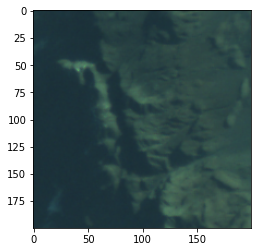

In [29]:
visualize_image(x_train, y_train, image_to_visualize)

[[[ 52  75  84]
  [ 52  76  84]
  [ 51  77  83]
  ...
  [ 69  97  93]
  [ 68 101  95]
  [ 67  97  95]]

 [[ 53  78  84]
  [ 53  78  84]
  [ 53  78  83]
  ...
  [ 68  97  93]
  [ 68 100  95]
  [ 68 102  96]]

 [[ 54  80  85]
  [ 54  80  85]
  [ 54  78  85]
  ...
  [ 67  95  94]
  [ 69  99  95]
  [ 70 101  96]]

 ...

 [[ 48  70  78]
  [ 48  71  79]
  [ 48  70  79]
  ...
  [ 89 120 104]
  [ 91 122 106]
  [ 92 124 107]]

 [[ 48  70  78]
  [ 48  70  79]
  [ 49  69  79]
  ...
  [ 88 118 104]
  [ 89 121 106]
  [ 90 123 106]]

 [[ 48  70  78]
  [ 48  70  79]
  [ 48  69  80]
  ...
  [ 89 118 104]
  [ 90 121 106]
  [ 91 123 105]]]


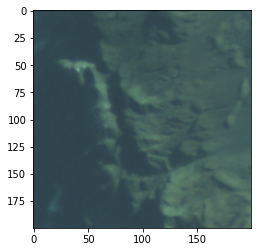

In [30]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
brightness_example = (tf.image.stateless_random_brightness(x_train[image_to_visualize]/255, 0.2, augmentation_seed)*255).numpy().astype(int)
print(brightness_example)
plt.imshow(brightness_example)

[[[ 32  55  64]
  [ 32  56  64]
  [ 31  57  63]
  ...
  [ 49  77  73]
  [ 48  81  75]
  [ 47  77  75]]

 [[ 33  58  64]
  [ 33  58  64]
  [ 33  58  63]
  ...
  [ 48  77  73]
  [ 48  80  75]
  [ 48  82  76]]

 [[ 34  60  65]
  [ 34  60  65]
  [ 34  58  65]
  ...
  [ 47  75  74]
  [ 49  79  75]
  [ 50  81  76]]

 ...

 [[ 28  50  58]
  [ 28  51  59]
  [ 28  50  59]
  ...
  [ 69 100  84]
  [ 71 102  86]
  [ 72 104  87]]

 [[ 28  50  58]
  [ 28  50  59]
  [ 29  49  59]
  ...
  [ 68  98  84]
  [ 69 101  86]
  [ 70 103  86]]

 [[ 28  50  58]
  [ 28  50  59]
  [ 28  49  60]
  ...
  [ 69  98  84]
  [ 70 101  86]
  [ 71 103  85]]]


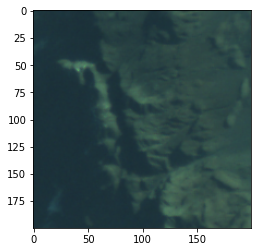

In [31]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_left_right_example = tf.image.stateless_random_flip_left_right(x_train[image_to_visualize], augmentation_seed).numpy().astype(int)
print(flip_left_right_example)
plt.imshow(flip_left_right_example)

[[[ 28  50  58]
  [ 28  50  59]
  [ 28  49  60]
  ...
  [ 69  98  84]
  [ 70 101  86]
  [ 71 103  85]]

 [[ 28  50  58]
  [ 28  50  59]
  [ 29  49  59]
  ...
  [ 68  98  84]
  [ 69 101  86]
  [ 70 103  86]]

 [[ 28  50  58]
  [ 28  51  59]
  [ 28  50  59]
  ...
  [ 69 100  84]
  [ 71 102  86]
  [ 72 104  87]]

 ...

 [[ 34  60  65]
  [ 34  60  65]
  [ 34  58  65]
  ...
  [ 47  75  74]
  [ 49  79  75]
  [ 50  81  76]]

 [[ 33  58  64]
  [ 33  58  64]
  [ 33  58  63]
  ...
  [ 48  77  73]
  [ 48  80  75]
  [ 48  82  76]]

 [[ 32  55  64]
  [ 32  56  64]
  [ 31  57  63]
  ...
  [ 49  77  73]
  [ 48  81  75]
  [ 47  77  75]]]


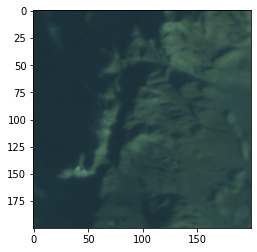

In [32]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
flip_up_down_example = tf.image.stateless_random_flip_up_down(x_train[image_to_visualize], augmentation_seed).numpy().astype(int)
print(flip_up_down_example)
plt.imshow(flip_up_down_example)

[[[ 32  55  64]
  [ 32  56  64]
  [ 31  57  63]
  ...
  [ 49  77  73]
  [ 48  81  75]
  [ 47  77  75]]

 [[ 33  58  64]
  [ 33  58  64]
  [ 33  58  63]
  ...
  [ 48  77  73]
  [ 48  80  75]
  [ 48  82  76]]

 [[ 34  60  65]
  [ 34  60  65]
  [ 34  58  65]
  ...
  [ 47  75  74]
  [ 49  79  75]
  [ 50  81  76]]

 ...

 [[ 28  50  58]
  [ 28  51  59]
  [ 28  50  59]
  ...
  [ 69 100  84]
  [ 71 102  86]
  [ 72 104  87]]

 [[ 28  50  58]
  [ 28  50  59]
  [ 29  49  59]
  ...
  [ 68  98  84]
  [ 69 101  86]
  [ 70 103  86]]

 [[ 28  50  58]
  [ 28  50  59]
  [ 28  49  60]
  ...
  [ 69  98  84]
  [ 70 101  86]
  [ 71 103  85]]]


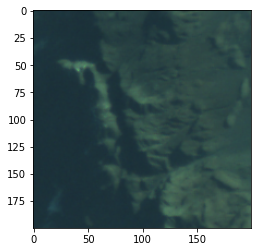

In [33]:
k = random.choice([0, 1, 2, 3])
rot90_example = tf.image.rot90(x_train[image_to_visualize], k=k).numpy().astype(int)
print(rot90_example)
plt.imshow(rot90_example)

[[[ 32  64  61]
  [ 32  64  60]
  [ 31  63  57]
  ...
  [ 49  77  63]
  [ 48  81  63]
  [ 47  77  64]]

 [[ 33  64  59]
  [ 33  64  59]
  [ 33  63  57]
  ...
  [ 48  77  62]
  [ 48  80  63]
  [ 48  82  64]]

 [[ 34  65  59]
  [ 34  65  59]
  [ 34  65  61]
  ...
  [ 47  75  64]
  [ 49  79  64]
  [ 50  81  65]]

 ...

 [[ 28  58  55]
  [ 28  59  56]
  [ 28  59  57]
  ...
  [ 69 100  73]
  [ 71 102  75]
  [ 72 104  75]]

 [[ 28  58  55]
  [ 28  59  57]
  [ 29  59  58]
  ...
  [ 68  98  73]
  [ 69 101  74]
  [ 70 103  74]]

 [[ 28  58  55]
  [ 28  59  57]
  [ 28  60  59]
  ...
  [ 69  98  73]
  [ 70 101  75]
  [ 71 103  73]]]


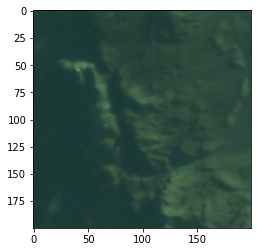

In [34]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
hue_example = tf.image.stateless_random_hue(x_train[image_to_visualize], 0.3, augmentation_seed).numpy().astype(int)
print(hue_example)
plt.imshow(hue_example)

[[[34 57 64]
  [34 58 64]
  [33 59 64]
  ...
  [46 74 71]
  [45 77 72]
  [45 74 72]]

 [[34 60 64]
  [34 60 64]
  [34 60 64]
  ...
  [45 74 71]
  [45 76 72]
  [45 77 73]]

 [[35 61 65]
  [35 61 65]
  [35 60 65]
  ...
  [45 72 72]
  [46 75 72]
  [47 77 73]]

 ...

 [[31 54 60]
  [31 54 61]
  [31 54 61]
  ...
  [61 91 79]
  [62 92 80]
  [63 93 81]]

 [[31 54 60]
  [31 54 61]
  [31 53 61]
  ...
  [60 89 79]
  [61 91 80]
  [62 93 80]]

 [[31 54 60]
  [31 54 61]
  [31 53 61]
  ...
  [61 89 79]
  [62 91 80]
  [62 93 80]]]


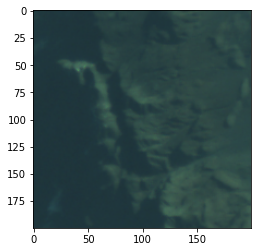

In [35]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
contrast_example = tf.image.stateless_random_contrast(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed).numpy().astype(int)
print(contrast_example)
plt.imshow(contrast_example)

[[[ 31  54  64]
  [ 31  55  64]
  [ 30  56  63]
  ...
  [ 48  77  72]
  [ 47  81  74]
  [ 46  77  74]]

 [[ 32  57  64]
  [ 32  57  64]
  [ 32  57  63]
  ...
  [ 47  77  72]
  [ 47  80  74]
  [ 47  82  75]]

 [[ 33  59  65]
  [ 33  59  65]
  [ 33  57  65]
  ...
  [ 46  75  73]
  [ 48  79  74]
  [ 49  81  75]]

 ...

 [[ 27  49  58]
  [ 27  50  59]
  [ 27  49  59]
  ...
  [ 68 100  83]
  [ 70 102  85]
  [ 71 104  86]]

 [[ 27  49  58]
  [ 27  49  59]
  [ 28  48  59]
  ...
  [ 67  98  83]
  [ 68 101  85]
  [ 69 103  85]]

 [[ 27  49  58]
  [ 27  49  59]
  [ 27  48  60]
  ...
  [ 68  98  83]
  [ 69 101  85]
  [ 70 103  84]]]


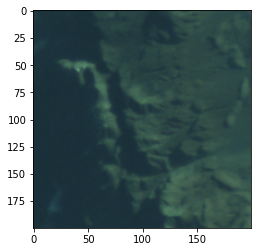

In [36]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
saturation_example = tf.image.stateless_random_saturation(x_train[image_to_visualize], 0.6, 1.4, augmentation_seed).numpy().astype(int)
print(saturation_example)
plt.imshow(saturation_example)

[[[ 36  53  69]
  [ 44  54  62]
  [ 43  63  59]
  ...
  [ 45  80  75]
  [ 56  76  72]
  [ 39  73  78]]

 [[ 39  50  71]
  [ 43  61  79]
  [ 26  47  48]
  ...
  [ 37  72  75]
  [ 35  83  74]
  [ 52  83  87]]

 [[ 35  56  65]
  [ 38  60  65]
  [ 28  52  53]
  ...
  [ 47  73  79]
  [ 50  72  72]
  [ 43  89  76]]

 ...

 [[ 37  40  62]
  [ 14  43  52]
  [ 22  44  61]
  ...
  [ 74  85  72]
  [ 54 104  89]
  [ 79  95  83]]

 [[ 21  42  50]
  [ 17  53  70]
  [ 36  45  58]
  ...
  [ 63  88  79]
  [ 84 104  84]
  [ 91 108  88]]

 [[ 36  59  52]
  [ 19  42  59]
  [ 27  43  52]
  ...
  [ 71 102  84]
  [ 59  93  85]
  [ 56  98  86]]]


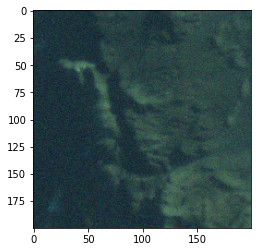

In [37]:
random_noise_example = (random_noise(x_train[image_to_visualize]/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255).astype(int)
print(random_noise_example)
plt.imshow(random_noise_example)

[[[29 52 59]
  [29 51 59]
  [29 51 59]
  ...
  [46 74 73]
  [46 74 74]
  [46 75 74]]

 [[29 51 59]
  [29 51 59]
  [29 51 59]
  ...
  [45 75 73]
  [45 75 74]
  [45 76 74]]

 [[29 51 59]
  [29 51 59]
  [29 52 59]
  ...
  [45 75 74]
  [45 76 74]
  [45 76 75]]

 ...

 [[28 49 58]
  [28 48 58]
  [27 48 58]
  ...
  [38 61 65]
  [37 60 64]
  [37 60 64]]

 [[28 50 58]
  [27 49 58]
  [27 49 59]
  ...
  [42 67 68]
  [41 66 66]
  [41 67 66]]

 [[28 50 58]
  [27 51 58]
  [26 51 59]
  ...
  [47 74 70]
  [45 72 69]
  [46 75 69]]]


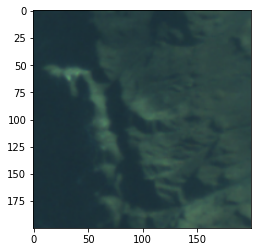

In [38]:
augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')
heigth = 200
width = 200
factor = random.choice(np.arange(0.8, 1.05, 0.05))
random_crop_example = tf.image.stateless_random_crop(x_train[image_to_visualize], [int(heigth*factor), int(width*factor), 3], augmentation_seed)
random_crop_example = tf.image.resize(random_crop_example, [heigth, width]).numpy().astype(int)
print(random_crop_example)
plt.imshow(random_crop_example)

#### Apply augmentations to all train images n times

In [39]:
%%time

num_augmentations = 20

if num_augmentations == 0:
  pass

else:

  x_train_augmented = np.copy(x_train)

  for n in range(1, num_augmentations+1):

    augmentation_seed = tf.random.uniform((2,), minval=0, maxval=65536).numpy().astype('int32')

    #augmentations = (tf.image.stateless_random_brightness(x_train/255, 0.2, augmentation_seed)*255).numpy().astype(int)

    augmentations = tf.image.stateless_random_flip_left_right(x_train, augmentation_seed).numpy().astype(int)

    augmentations = tf.image.stateless_random_flip_up_down(augmentations, augmentation_seed).numpy().astype(int)

    k = random.choice([0, 1, 2, 3])
    augmentations = np.array([tf.image.rot90(image, k=k) for image in augmentations]).astype(int)

    augmentations = tf.image.stateless_random_hue(augmentations, 0.3, augmentation_seed).numpy().astype(int)

    augmentations = tf.image.stateless_random_contrast(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype(int)

    augmentations = tf.image.stateless_random_saturation(augmentations, 0.6, 1.4, augmentation_seed).numpy().astype(int)

    augmentations = np.array([random_noise(image/255, mode='gaussian', mean=0, var=0.001, seed=seed)*255 for image in augmentations]).astype(int)

    #factor = random.choice(np.arange(0.8, 1.05, 0.05))
    #random_crop = np.array([tf.image.stateless_random_crop(image, [int(heigth*factor), int(width*factor), 3], augmentation_seed) for image in augmentations])
    #augmentations = tf.image.resize(random_crop, [heigth, width]).numpy().astype(int)

    x_train_augmented = np.append(x_train_augmented, augmentations, axis=0)

  y_train_augmented = np.concatenate([y_train] * (num_augmentations + 1))

CPU times: user 25.3 s, sys: 2.38 s, total: 27.7 s
Wall time: 31.8 s


In [40]:
x_train.shape

(64, 200, 200, 3)

In [41]:
augmentations.shape

(64, 200, 200, 3)

In [42]:
x_train_augmented.shape

(1344, 200, 200, 3)

In [43]:
y_train.shape

(64,)

In [44]:
y_train_augmented.shape

(1344,)

### Shuffle and convert images and labels

In [45]:
if num_augmentations == 0:
  x_train, y_train = shuffle(x_train, y_train, random_state=seed)
  x_train = tf.convert_to_tensor(x_train)
  y_train = tf.convert_to_tensor(y_train, dtype=np.int32)

else:
  x_train_augmented, y_train_augmented = shuffle(x_train_augmented, y_train_augmented, random_state=seed)
  x_train = tf.convert_to_tensor(x_train_augmented)
  y_train = tf.convert_to_tensor(y_train_augmented, dtype=np.int32)

  del x_train_augmented, y_train_augmented
  gc.collect()

x_val, y_val = shuffle(x_val, y_val, random_state=seed)
x_val = tf.convert_to_tensor(x_val)
y_val = tf.convert_to_tensor(y_val, dtype=np.int32)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(1344, 200, 200, 3) (1344,) (16, 200, 200, 3) (16,)


# 5. Model training

We provide now an example on how you can train your model by using standard supervised learning. Training loss (`SparseCategoricalCrossentropy`) and `Accuracy` are shown for simplicity and for an easier interpretation of the training outcome, despite your submission will be evaluated by using the metric **1 - Cohen's kappa** [metric](https://en.wikipedia.org/wiki/Cohen's_kappa). For more information on scoring, please refer to [Scoring](https://kelvins.esa.int/opssat/scoring/).

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[keras.metrics.SparseCategoricalAccuracy()])

With this model and the dataset provided, please do your best!

In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
%%time
# load data, data augmentation, training, overfitting, transfer-learning etc.
history=model.fit(x_train, y_train, epochs=100, verbose=1, batch_size=8, callbacks=[callback], validation_data=(x_val,y_val), shuffle=False)

Epoch 1/100
168/168 [==============================] - 18s 64ms/step - loss: 3.8868 - sparse_categorical_accuracy: 0.1585 - val_loss: 4.6043 - val_sparse_categorical_accuracy: 0.1250
Epoch 2/100
168/168 [==============================] - 10s 60ms/step - loss: 2.9332 - sparse_categorical_accuracy: 0.1763 - val_loss: 2.5790 - val_sparse_categorical_accuracy: 0.1250
Epoch 3/100
168/168 [==============================] - 10s 59ms/step - loss: 2.6547 - sparse_categorical_accuracy: 0.2031 - val_loss: 2.8174 - val_sparse_categorical_accuracy: 0.1250
Epoch 4/100
168/168 [==============================] - 10s 59ms/step - loss: 2.4055 - sparse_categorical_accuracy: 0.2173 - val_loss: 3.5230 - val_sparse_categorical_accuracy: 0.1250
Epoch 5/100
168/168 [==============================] - 10s 58ms/step - loss: 2.1254 - sparse_categorical_accuracy: 0.2612 - val_loss: 2.9072 - val_sparse_categorical_accuracy: 0.1250
Epoch 6/100
168/168 [==============================] - 10s 58ms/step - loss: 1.9286 -

In [ ]:
gc.collect()

### Plot loss and accuracy

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3))

ax0.plot(history.history['loss'], label='loss')
ax0.plot(history.history['val_loss'], label='val_loss')
ax0.set_title('loss')
ax0.set_xlabel('epoch')
ax0.legend()

ax1.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
ax1.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
ax1.set_title('sparse_categorical_accuracy')
ax1.set_xlabel('epoch')
ax1.legend()

plt.tight_layout()           
plt.show()

In [ ]:
print('min val loss: {}'.format(round(min(history.history['val_loss']), 3)))

Calculating the **1 - Cohen's kappa** score of the trained model on the trained dataset.

In [ ]:
%%time
predictions = evaluate_model(x_train, y_train)

In [ ]:
get_confusion_matrix(y_train, predictions)

In [ ]:
visualize_image(x_train.numpy().astype(int), y_train.numpy(), image_to_visualize, pred=True, predictions=predictions)

In [ ]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_train, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_train, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_train, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_train, predictions, average='micro'), 3)))

print(metrics.classification_report(y_train, predictions))

### Evaluation on val set

In [ ]:
%%time
predictions = evaluate_model(x_val, y_val)

In [ ]:
get_confusion_matrix(y_val, predictions)

In [ ]:
visualize_image(x_val.numpy().astype(int), y_val.numpy(), 10, pred=True, predictions=predictions)

In [ ]:
print('Accuracy: {:0.3f}'.format(round(metrics.accuracy_score(y_val, predictions), 3)))

# What proportion of positive identifications was actually correct?
print('Precision: {:0.3f}'.format(round(metrics.precision_score(y_val, predictions, average='micro'), 3)))

# What proportion of actual positives was identified correctly?
print('Recall: {:0.3f}'.format(round(metrics.recall_score(y_val, predictions, average='micro'), 3)))

print('F1-Score: {:0.3f}'.format(round(metrics.f1_score(y_val, predictions, average='micro'), 3)))

print(metrics.classification_report(y_val, predictions))

# 6. Saving and loading trained model

The trained model can be now saved by using HDF5-format that is the only accepted for submission. The name `test.h5` will be used.

In [ ]:
#Saving model
model.save_weights('v28.h5')

The trained model can be also loaded for further testing. 

In [ ]:
#model = EfficientNetLiteB0(classes=num_classes, weights=None, input_shape=input_shape, classifier_activation=None)
model.load_weights('v28.h5')

The model will be now compiled and tested again. You should get the same score as before saving and loading. 

In [ ]:
#Model shall be compiled before testing.
model.compile()

predictions = evaluate_model(x_train, y_train)